# 基于backtrader的量化交易策略


* 从量化平台（掘金量化，米筐，聚宽，优矿）到开源库

* backtrader的安装

pip install backtrader[plotting] -i http://mirrors.aliyun.com/pypi/simple/ --trusted-host=mirrors.aliyun.com

* 解决无法作图的办法：

https://blog.csdn.net/weixin_41494909/article/details/119427922


## backtrader的交易策略编写逻辑

https://blog.csdn.net/qq_41578115/article/details/122525397

https://blog.csdn.net/h00cker/article/details/120911268

* 编写形式，class(next) addstrategy

* 交易策略的真实逻辑：以bar（交易日）为周期，重复运行next函数，对应的就是导入的data序列，每一对应一次next函数的重复运行（当前序列始终对应的是0）

* 为了提供交易的进行与记录，底层提供若干函数（self.order，self.sell）和变量可以调取（self.position，self.datetime）

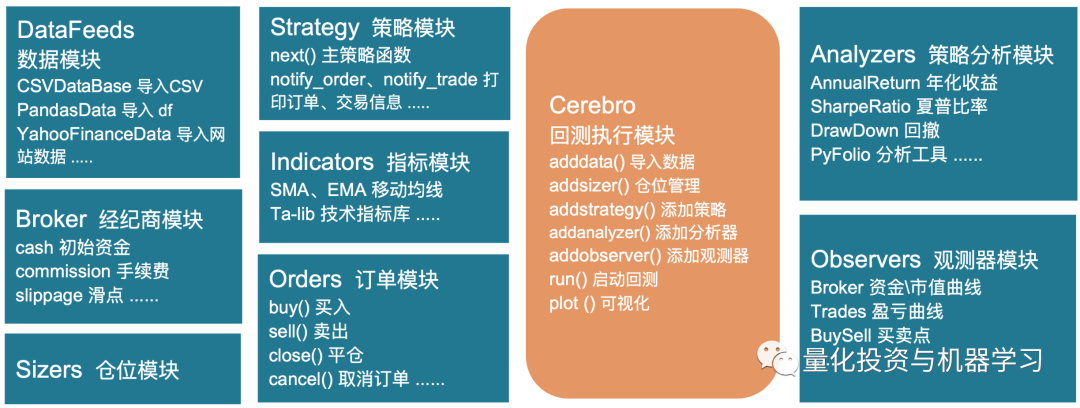

In [45]:
from IPython.display import Image
Image(filename="backtrader0.png")

### 第一个交易策略

* classwork 1

* 正确运行你的第一个策略，并作出图形

In [1]:
import pandas as pd  
import talib
from datetime import datetime
import backtrader as bt
import matplotlib.pyplot as plt
import akshare as ak
import numpy as np
%matplotlib inline   

#正常显示画图时出现的中文和负号
from pylab import mpl

mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

In [2]:
class my_strategy2(bt.Strategy):
    #全局设定交易策略的参数

    def __init__(self):
        # 初始化交易指令、买卖价格和手续费
        self.order = None

    def next(self):
        # 检查是否持仓 
        if not self.position: # 没有持仓
            #self.order = self.buy(size=500)
            #self.order_target_value(target=10000)
            #self.order_target_size(target=10000)(佣金)
            self.order_target_percent(target=0.99)
            #print(self.datetime.date(0),self.position)

In [2]:
def get_data(symbol,start_date,end_date):
    stock_pinan = ak.stock_zh_a_hist(symbol=symbol, period="daily", start_date=start_date, end_date=end_date, adjust="qfq")
    stock_pinan.columns=["date","open","close","high","low","volume",'成交额', '振幅', '涨跌幅', '涨跌额', '换手率']
    stock_pinan["date"]=pd.to_datetime(stock_pinan["date"])
    stock_pinan['openinterest']=0
    stock_pinan.set_index("date",inplace=True)
    return stock_pinan[["open","high","low","close","volume","openinterest"]]

In [4]:
def huice_run(start,end,stock,strategy):
  # 加载数据
    data = bt.feeds.PandasData(dataname=stock,fromdate=start,todate=end)

    # 初始化cerebro回测系统设置                           
    cerebro = bt.Cerebro()  
    #将数据传入回测系统
    cerebro.adddata(data) 
    # 将交易策略加载到回测系统中
    cerebro.addstrategy(strategy) 
    # 设置初始资本为10,000
    startcash = 10000
    cerebro.broker.setcash(startcash) 
    # 设置交易手续费为 0.2%
    cerebro.broker.setcommission(commission=0.002) 


    print(start.date(),end.date())
    print('初始资金: %.2f' % cerebro.broker.getvalue())
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name = 'SharpeRatio')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DW')
    results = cerebro.run()
    strat = results[0]
    print('最终资金: %.2f' % cerebro.broker.getvalue())
    print('夏普比率:', strat.analyzers.SharpeRatio.get_analysis())
    print('回撤指标:', strat.analyzers.DW.get_analysis())
    
    return cerebro

In [5]:
start="20100101"
end='20200331'
stock_pinan=get_data("600000",start,end)

In [6]:
huice_result=huice_run(datetime(2010, 3, 31),datetime(2020, 3, 31),stock_pinan,my_strategy2)

2010-03-31 2020-03-31
初始资金: 10000.00
最终资金: 16459.51
夏普比率: OrderedDict([('sharperatio', 0.2593314762248785)])
回撤指标: AutoOrderedDict([('len', 659), ('drawdown', 26.614232705296246), ('moneydown', 5969.239999999998), ('max', AutoOrderedDict([('len', 1117), ('drawdown', 77.8737319632789), ('moneydown', 8500.499999999998)]))])


<IPython.core.display.Javascript object>


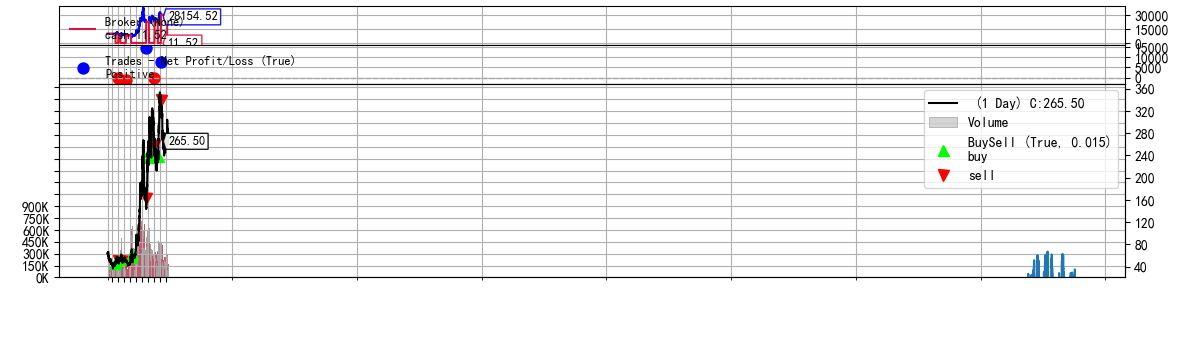

[[<Figure size 432x288 with 4 Axes>]]

In [7]:
huice_result.plot()

## 交易方式（classwork 2）

* 读取比亚迪002594 2018年3月到2023年3月的数据，并导入策略

* 每天买100股

* 使用order_target三兄弟用三种方式第一天全部买入

* 定时交易，在某一天全部买入，某一天全部卖出

In [3]:
start="20180301"
end='20230301'
stock_byd=get_data("002594",start,end)

In [9]:
class my_strategy_time(bt.Strategy):
    #全局设定交易策略的参数

    def __init__(self):
        # 初始化交易指令、买卖价格和手续费
        self.order = None

    def next(self):
        # 检查是否持仓 
        if self.datetime.date(0)==datetime(2019, 6, 24).date(): # 没有持仓
            #self.order = self.buy(size=500)
            #self.order_target_value(target=10000)
            #self.order_target_size(target=10000)(佣金)
            self.order_target_percent(target=0.99)
            #print(self.datetime.date(0),self.position)

In [10]:
huice_result=huice_run(datetime(2018, 3, 1),datetime(2023, 3, 1),stock_pinan,my_strategy_time)

2018-03-01 2023-03-01
初始资金: 10000.00
最终资金: 52437.75
夏普比率: OrderedDict([('sharperatio', 0.49110831394808974)])
回撤指标: AutoOrderedDict([('len', 167), ('drawdown', 24.824795873910773), ('moneydown', 17316.29999999998), ('max', AutoOrderedDict([('len', 167), ('drawdown', 46.112539151396454), ('moneydown', 24339.350000000006)]))])


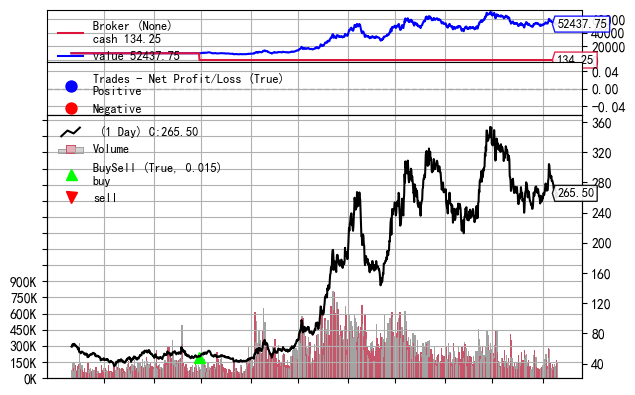

In [13]:
#%matplotlib inline 
huice_result.plot()[0][0]

## 基于事件的交易策略

* 使用pandas编写策略，仅仅用backtrader作为交易结果分析器

### 均线突破（classwork2）

* 请做出股票收盘价与30日均线图

* 定制策略，股价高于30日均线的时候购买，低于30日均线的时候平仓

https://zhuanlan.zhihu.com/p/140425363

https://zhuanlan.zhihu.com/p/402559960


In [9]:
stock_byd

,open,high,low,close,volume,openinterest
date,,,,,,
2018-03-01,62.29,62.78,61.84,62.61,74935,0
2018-03-02,61.85,62.70,61.71,62.21,59277,0
2018-03-05,62.34,65.24,62.25,64.46,149505,0
2018-03-06,64.47,66.14,64.14,65.92,149686,0
2018-03-07,65.34,65.83,63.84,63.87,94942,0
...,...,...,...,...,...,...
2023-02-23,269.90,271.67,268.50,270.44,100358,0
2023-02-24,269.02,269.88,267.00,267.58,66868,0
2023-02-27,265.00,265.89,258.00,259.81,169704,0


In [21]:
talib.SMA(stock_pinan.close,20).head(11)

date
2018-03-01   NaN
2018-03-02   NaN
2018-03-05   NaN
2018-03-06   NaN
2018-03-07   NaN
2018-03-08   NaN
2018-03-09   NaN
2018-03-12   NaN
2018-03-13   NaN
2018-03-14   NaN
2018-03-15   NaN
dtype: float64

In [15]:
stock_pinan_close=stock_pinan.close
stock_pinan_close_30=talib.SMA(stock_pinan.close,30)

<AxesSubplot:xlabel='date'>

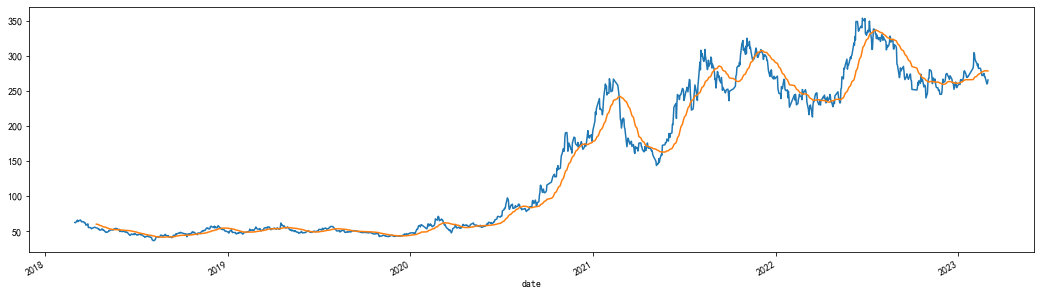

In [16]:
%matplotlib inline 
stock_pinan_close.plot(figsize=(18,5))
stock_pinan_close_30.plot()

In [16]:
i_1=stock_pinan_close_30.index[0]
buy_date=[]
sell_date=[]
for i in stock_pinan_close_30.index[1:]:
    if stock_pinan_close[i]>stock_pinan_close_30[i] and stock_pinan_close[i_1]<stock_pinan_close_30[i_1]:
        buy_date.append(i.date())
    if stock_pinan_close[i]<stock_pinan_close_30[i] and stock_pinan_close[i_1]>stock_pinan_close_30[i_1]:
        sell_date.append(i.date())
    i_1=i

In [63]:
class my_strategy_date(bt.Strategy):
    #全局设定交易策略的参数

    def __init__(self):
        # 初始化交易指令、买卖价格和手续费
        self.order = None

    def next(self):
        # 检查是否持仓 
        if self.datetime.date(0) in buy_date: # 没有持仓
            self.order_target_percent(target=0.99)
        if self.datetime.date(0) in sell_date: # 没有持仓
            self.order_target_percent(target=0)


In [62]:
buy_date

[datetime.date(2022, 8, 18),
 datetime.date(2022, 9, 26),
 datetime.date(2022, 10, 12),
 datetime.date(2022, 11, 1),
 datetime.date(2022, 12, 1),
 datetime.date(2023, 1, 6)]

In [104]:
huice_result=huice_run(datetime(2018, 3, 1),datetime(2023, 3, 1),stock_byd,my_strategy_date)

2018-03-01 2023-03-01
初始资金: 10000.00
最终资金: 6733.87
夏普比率: OrderedDict([('sharperatio', -0.14340816298290437)])
回撤指标: AutoOrderedDict([('len', 530), ('drawdown', 47.09667563492754), ('moneydown', 5994.761159999996), ('max', AutoOrderedDict([('len', 543), ('drawdown', 48.36836058016646), ('moneydown', 6156.629219999996)]))])


<IPython.core.display.Javascript object>


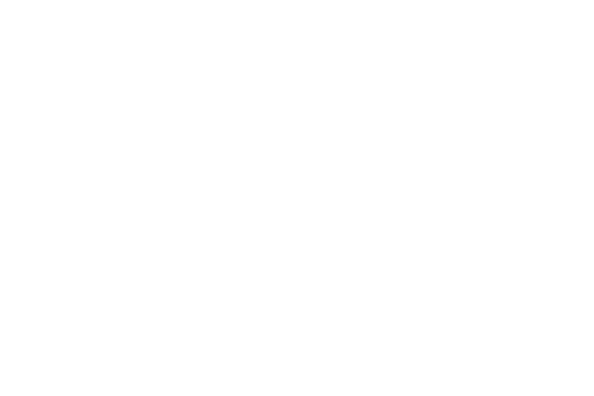

[<Figure size 432x288 with 4 Axes>]

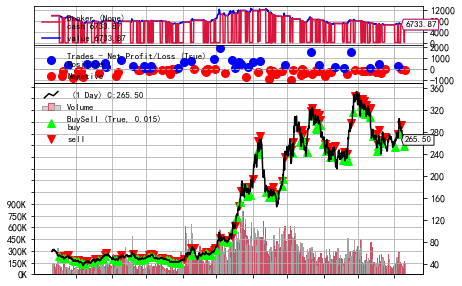

In [106]:
#%matplotlib inline 
huice_result.plot()[0]

## MACD

https://zhuanlan.zhihu.com/p/348987788

* 指数移动平均

EMA(t)=平滑常数\*当前价格+(1-平滑常数)*EMA(t-1)

* 指数平滑异同移动平均线（moving average convergence-divergence, MACD）。MACD是以三个指数移动平均为基础，以两条曲线的形式出现在图表中，其两条线的交叉点，是一种交易信号。

最初的MACD指标由两条线组成：一条实线（叫作MACD线）和一条虚线（叫作信号线）。MACD线由两个指数移动平均（EMA）计算而来，其对价格的反应相对较快。信号线是以MACD线为基础，通过对MACD线以EMA的方式进行运算，实现对MACD线的平滑，其对价格变动的反应相对较慢。在阿佩尔最初的体系中，较快的MACD线穿过较慢的信号线上升或者下降，为买入或者卖出的信号。大多数技术分析软件都提供MACD指标。

手工做出MACD指标的步骤如下：

（1）计算12日收盘价的EMA；

（2）计算26日收盘价的EMA；

（3）用12日收盘价的EMA减去26日收盘价的EMA，将其差值画成一条实线，这就是较快的MACD线；也叫离差值（DIF）

（4）计算这条实线的9日EMA，将其结果画成一条虚线，这就是较慢的信号线。也叫离差平均值（DEA）。

（5）（DIF-DEA）×2即为MACD值。

每一个价格都反映了所有的市场参与者那一刻对股票价值的共识。移动平均值反映了一段时间内的市场价值共识的平均水平——它像是所有的市场参与者共识的连环照。较长的移动平均反映的是较长时间周期内市场价值共识的平均水平，而较短的移动平均则反映了较短时间周期内市场价值共识的平均水平。

MACD线和信号线的交点表明了市场中空方和多方实力变换的平衡点。较快的MACD线反映的是短期内大众的心理变化，而较慢的信号线则反映了大众心理在较长期的变化。当较快的MACD线上升超过信号线时，表示多方主导了市场，这时候最好做多方；当较快的线落到较慢的信号线下面时，表示空方主导了市场，做空方比较有利。

* MACD柱状线

相比原始的MACD线，MACD柱状线能够提供更深刻的关于多空力量均衡的信息。它不仅能分辨出哪种力量处于主导地位，而且能够分辨其力量是在逐渐增强还是在减弱。MACD柱状线是技术分析师最好用的工具之一。

MACD柱状线=MACD线-信号线

MACD柱状线测量的是MACD线和信号线之间的差值。它将差值画为一根根柱状线——为一系列垂直的线条。

MACD柱状线的斜率方向揭示了市场中的主导力量。向上倾斜的MACD柱状线表示多方的力量在增强，而向下倾斜的MACD柱状线则意味着空方的力量在增强。


策略的统一思路1：追涨杀跌

* MACD简单策略：

快线DIF与慢线DEA都大于零，快线向上突破慢线，则买入

快线DIF与慢线DEA都小于零，快线向下突破慢线，则卖出

### classwork 3

* 通过talib实现byd的macd线

* 可视化macd线

https://blog.csdn.net/qq_45222558/article/details/124553831

In [76]:
x,y,z=talib.MACD(stock_byd.close,fastperiod=6, slowperiod=20, signalperiod=9)

In [77]:
i_1=z.index[32]
buy_date=[]
sell_date=[]
for i in z.index[33:]:
    if x[i]>0 and y[i]>0 and z[i_1]<0 and z[i]>0:
        buy_date.append(i.date())
    if x[i]<0 and y[i]<0 and z[i_1]>0 and z[i]<0:
        sell_date.append(i.date())
    i_1=i

In [73]:
sell_date

[datetime.date(2018, 5, 4),
 datetime.date(2018, 5, 31),
 datetime.date(2018, 7, 17),
 datetime.date(2018, 8, 1),
 datetime.date(2019, 1, 31),
 datetime.date(2019, 9, 25),
 datetime.date(2019, 10, 30),
 datetime.date(2019, 11, 18),
 datetime.date(2021, 5, 6),
 datetime.date(2022, 1, 28),
 datetime.date(2022, 2, 11),
 datetime.date(2022, 3, 7),
 datetime.date(2022, 5, 10),
 datetime.date(2022, 8, 24),
 datetime.date(2022, 9, 30),
 datetime.date(2022, 10, 28),
 datetime.date(2022, 11, 17)]

In [25]:
help(talib.MACD)

Help on function MACD in module talib._ta_lib:

MACD(...)
    MACD(real[, fastperiod=?, slowperiod=?, signalperiod=?])
    
    Moving Average Convergence/Divergence (Momentum Indicators)
    
    Inputs:
        real: (any ndarray)
    Parameters:
        fastperiod: 12
        slowperiod: 26
        signalperiod: 9
    Outputs:
        macd
        macdsignal
        macdhist



In [10]:
x,y,z=talib.MACD(stock_byd.close[1000:],fastperiod=12, slowperiod=26, signalperiod=9)

In [ ]:
x-DIF  y-DEA, Z macd

In [13]:
-0.508938-1.980495

-2.489433

In [12]:
pd.concat([x,y,z],axis=1)

,0,1,2
date,,,
2022-04-13,NaN,NaN,NaN
2022-04-14,NaN,NaN,NaN
2022-04-15,NaN,NaN,NaN
2022-04-18,NaN,NaN,NaN
2022-04-19,NaN,NaN,NaN
...,...,...,...
2023-02-23,-0.508938,1.980495,-2.489433
2023-02-24,-1.182370,1.347922,-2.530293
2023-02-27,-2.316343,0.615069,-2.931412


In [14]:
from pyecharts import options as opts
from pyecharts.commons.utils import JsCode
from pyecharts.charts import Kline, Line, Bar, Grid

In [80]:
L_macd=Line()
L_macd.add_xaxis(x.index.tolist())
L_macd.add_yaxis("DIF",x.tolist(),label_opts=opts.LabelOpts(is_show=False))
L_macd.render_notebook()

In [81]:
L_macdsingle=Line()
L_macdsingle.add_xaxis(y.index.tolist())
L_macdsingle.add_yaxis("DEA",y.tolist(),label_opts=opts.LabelOpts(is_show=False))
L_macdsingle.render_notebook()

In [82]:
B_MACDhist=Bar()
B_MACDhist.add_xaxis(z.index.tolist())
B_MACDhist.add_yaxis("MACD",z.tolist()*2,label_opts=opts.LabelOpts(is_show=False),
                     itemstyle_opts=opts.ItemStyleOpts(
                color=JsCode(
                    """
                        function(params) {
                            var colorList;
                            if (params.data >= 0) {
                              colorList = '#ef232a';
                            } else {
                              colorList = '#14b143';
                            }
                            return colorList;
                        }
                        """
                )
            ),)
B_MACDhist.render_notebook()

In [83]:
B_L_L=B_MACDhist.overlap(L_macdsingle)
B_L_L=B_L_L.overlap(L_macd)
B_L_L.set_global_opts(legend_opts=opts.LegendOpts(is_show=False))
B_L_L.render_notebook()

In [24]:
stock_byd.index

DatetimeIndex(['2018-03-01', '2018-03-02', '2018-03-05', '2018-03-06',
               '2018-03-07', '2018-03-08', '2018-03-09', '2018-03-12',
               '2018-03-13', '2018-03-14',
               ...
               '2023-02-16', '2023-02-17', '2023-02-20', '2023-02-21',
               '2023-02-22', '2023-02-23', '2023-02-24', '2023-02-27',
               '2023-02-28', '2023-03-01'],
              dtype='datetime64[ns]', name='date', length=1215, freq=None)

In [26]:
y1=[]
for i,j in stock_byd[["open","close","low","high"]][1000:].iterrows():
    y1.append(j.tolist()[0:4])

In [84]:
K=Kline()
K.add_xaxis(stock_byd.index.tolist()[1000:])
K.add_yaxis("byd",y1)
K.set_global_opts(datazoom_opts=opts.DataZoomOpts(is_show=True,xaxis_index=[0,1]))
K.render_notebook()

In [85]:
grid_chart = Grid(init_opts=opts.InitOpts(width="700px", height="400px"))
grid_chart.add(
        K,
        grid_opts=opts.GridOpts(pos_left="3%", pos_right="1%", height="50%"),
    )

grid_chart.add(
        B_L_L,
        grid_opts=opts.GridOpts(
            pos_left="3%", pos_right="1%", pos_top="70%", height="20%"
        ),
    )

grid_chart.render_notebook()

### classwork 4

* 完成MACD策略


## 动量

https://www.20on.com/232832.html

* MTM指标原理

动量指标的计算，就是利用恒速缓冲的原则，来观测股价涨跌速度的本质从而决定投资的行为。比如有时股价虽上涨（或下跌），但动量值下降（或上升），这表明股市有反转的迹象，投资者则需要及时调整投资行为，不可再做多了。动量值就起这个提醒的作用。
股价上升下降既然是恒速、缓冲的，那么从理论上讲，在此期间内，股价的涨跌区间应相对一致。因此，动量指标就是尽量反映出涨跌区间的位移。

* MTM计算方法

MTM计算公式比较直观简单，以当日的收盘价减去昨日的收盘价，固定天数一般定为10天，然后将10天的差值相加得出动量值。

* 对MTM的分析

1、一般讲，股指或股价上升，动量值会随之上升。但动量值有时反映出转机的迹象。如果股市排除其他非技术影响，MTM大体还是可以反映出股市速度快慢的。

2、MTM与MA（移动平均线）配合使用效果较好。其主要方法是:在股指上升时，MTM下降曲线与MA上升曲线相互交叉时，在交叉点处投资者应及时卖出股票。因为此时空方力量开始行动，再一味做多，将被套牢。在股指下降时，MTM上升曲线与MA下降曲线相互交叉时，在交叉点处，投资者应大胆买进股票。因为此时空方力昼减弱，如一再做空，将耽误时机失去买低价股票的机会

3、MTM与MA配合使用时，周期均定在10天。

### classwork 5

1,计算byd股票的动量

2,基于以上方法对byd股票编写单股动量策略

In [87]:
stock_byd.close

date
2018-03-01     62.61
2018-03-02     62.21
2018-03-05     64.46
2018-03-06     65.92
2018-03-07     63.87
               ...  
2023-02-23    270.44
2023-02-24    267.58
2023-02-27    259.81
2023-02-28    260.80
2023-03-01    265.50
Name: close, Length: 1215, dtype: float64

In [88]:
64.46-62.61

1.8499999999999943

In [110]:
dongliang=talib.MOM(stock_byd.close, timeperiod=20)
MA10=talib.SMA(dongliang, timeperiod=10)

<AxesSubplot:xlabel='date'>

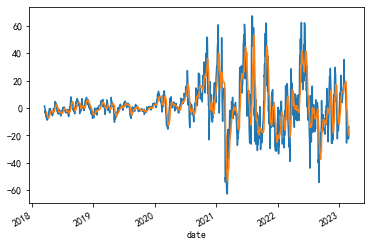

In [100]:
dongliang.plot()
MA10.plot()

In [94]:
dongliang[11:]

date
2018-03-16     1.36
2018-03-19    -0.87
2018-03-20    -3.78
2018-03-21    -1.93
2018-03-22    -2.28
              ...  
2023-02-23   -17.89
2023-02-24   -14.28
2023-02-27   -22.51
2023-02-28   -21.17
2023-03-01   -13.50
Length: 1204, dtype: float64

In [111]:
i_1=dongliang.index[11]
buy_date=[]
sell_date=[]
for i in dongliang.index[12:]:
    if dongliang[i]>0:
        buy_date.append(i.date())
    if dongliang[i]<0:
        sell_date.append(i.date())
    i_1=i

In [112]:
huice_result=huice_run(datetime(2018, 3, 1),datetime(2023, 3, 1),stock_byd,my_strategy_date)

2018-03-01 2023-03-01
初始资金: 10000.00
最终资金: 38359.72
夏普比率: OrderedDict([('sharperatio', 0.5137047910342706)])
回撤指标: AutoOrderedDict([('len', 167), ('drawdown', 22.471066296610452), ('moneydown', 11118.221940000003), ('max', AutoOrderedDict([('len', 205), ('drawdown', 26.30645404924799), ('moneydown', 12547.573619999996)]))])


<IPython.core.display.Javascript object>


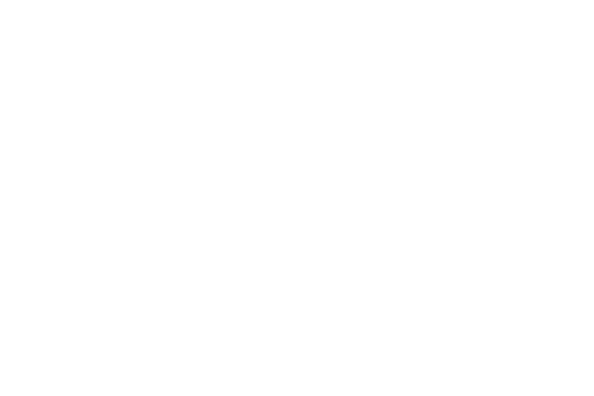

[[<Figure size 432x288 with 4 Axes>]]

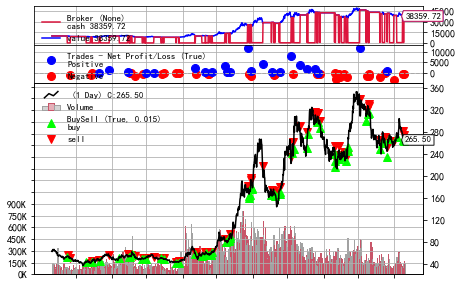

In [113]:
huice_result.plot()

<AxesSubplot:xlabel='date'>

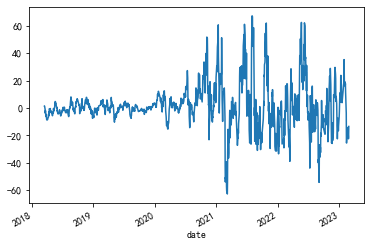

In [91]:
%matplotlib inline 
dongliang.plot()

## RSI

https://baike.baidu.com/item/RSI%E6%8C%87%E6%A0%87/7459334?fr=aladdin

RSI的原理简单来说是以数字计算的方法求出买卖双方的力量对比，反映市场买卖双方的供求情况。

譬如有100个人面对一件商品，如果50个人以上要买，竞相抬价，商品价格必涨；相反，如果50个人以上争着卖出，价格自然下跌。

强弱指标理论认为，任何市价的大涨或大跌，均在0—100之间变动，根据常态分配，认为RSI值多在30—70之间变动，通常RSI值在80甚至90时被认为市场已达到超买状态（Overbought）,至此市场价格自然会回落调整。当价格低跌至20—30以下时，即被认为是超卖（Oversold），市价将出现反弹回升。

追涨杀跌

涨够了---抛
跌够了---买

* RSI策略《量化投资以Python为工具》

以RSI6 与RSI24为例 当RSI6大于80或者RSI6向下穿过RSI24时为卖出信号；当RSI6小于20或者RSI6向上穿过RSI24时为买入信号；

### classwork 6

1,做出byd的RSI线

2,写一个RSI策略

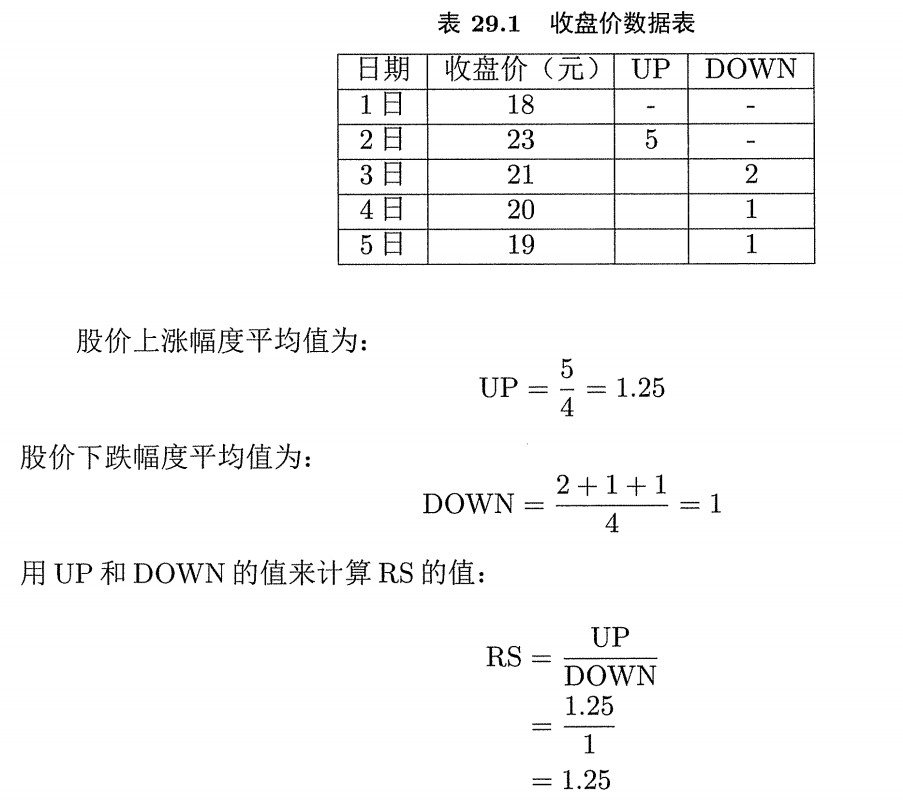

In [56]:
Image(filename="rsi.png",width=500)
#RSI的计算方法

In [134]:
rsi_6=talib.RSI(stock_byd.close, timeperiod=6)
rsi_24=talib.RSI(stock_byd.close, timeperiod=24)

<IPython.core.display.Javascript object>


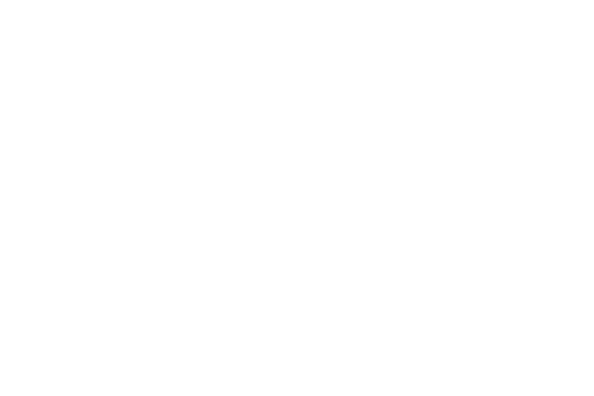

<AxesSubplot:xlabel='date'>

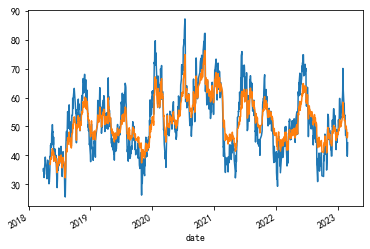

In [130]:
rsi_6.plot()
rsi_24.plot()

In [116]:
rsi_24.index[24]

Timestamp('2018-04-04 00:00:00')

In [135]:
i_1=rsi_24.index[24]
buy_date=[]
sell_date=[]
for i in rsi_24.index[24:]:
    if (rsi_6[i]>rsi_24[i] and rsi_6[i_1]<rsi_24[i_1]) or rsi_6[i]<20:
        buy_date.append(i.date())
    if (rsi_6[i]<rsi_24[i] and rsi_6[i_1]>rsi_24[i_1]) or rsi_6[i]>80:
        sell_date.append(i.date())
    i_1=i

In [136]:
huice_result=huice_run(datetime(2018, 3, 1),datetime(2023, 3, 1),stock_byd,my_strategy_date)

2018-03-01 2023-03-01
初始资金: 10000.00
最终资金: 6096.47
夏普比率: OrderedDict([('sharperatio', -0.16996596143301268)])
回撤指标: AutoOrderedDict([('len', 506), ('drawdown', 55.682799703326346), ('moneydown', 7659.97562), ('max', AutoOrderedDict([('len', 629), ('drawdown', 63.43188484110204), ('moneydown', 8725.97452)]))])


<IPython.core.display.Javascript object>


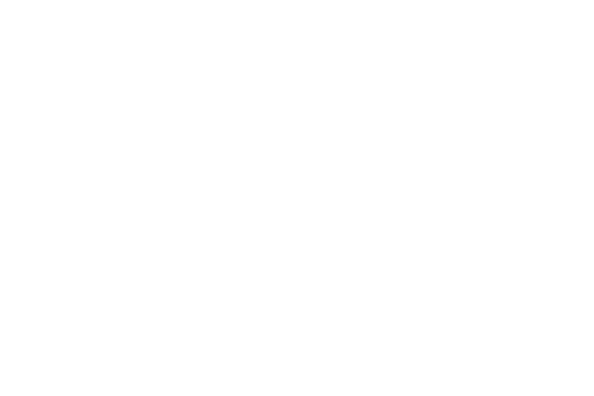

[[<Figure size 432x288 with 4 Axes>]]

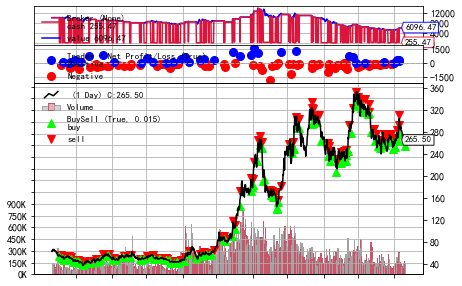

In [137]:
huice_result.plot()

## 唐奇安通道

https://zhuanlan.zhihu.com/p/111343952

https://baijiahao.baidu.com/s?id=1715583303182366600&wfr=spider&for=pc

In [4]:
up = talib.MAX(stock_byd.close, 20)
down = talib.MIN(stock_byd.close, 20)

<AxesSubplot:xlabel='date'>

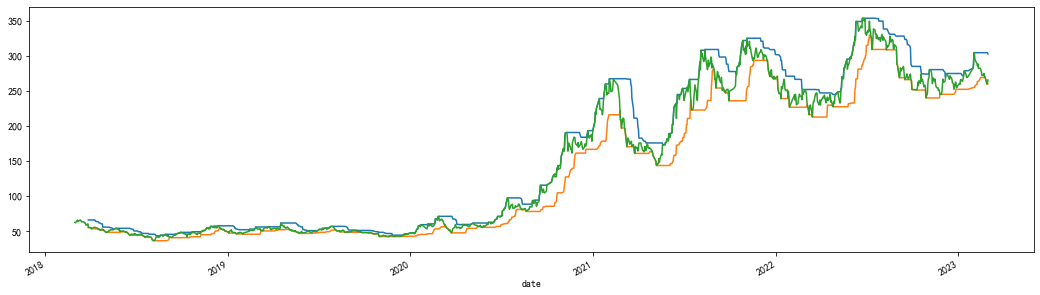

In [5]:
up.plot(figsize=(18,5))
down.plot()
stock_byd.close.plot()

## 布林带

http://www.30daydo.com/article/200

https://www.zhihu.com/zvideo/1322285705142185984

1、日BOLL指标的计算公式

中轨线=N日的移动平均线

上轨线=中轨线＋两倍的标准差

下轨线=中轨线－两倍的标准差

2、日BOLL指标的计算过程

1）计算MA

MA=N日内的收盘价之和÷N2）计算标准差MD

MD=平方根N日的（C－MA）的两次方之和除以N3）计算MB、UP、DN线

MB=（N－1）日的MA

UP=MB＋2×MD

DN=MB－2×MD在股市分析软件中，BOLL指标一共由四条线组成，即上轨线UP 、中轨线MB、下轨线DN和价格线。

In [94]:
help(talib.BBANDS)

Help on function BBANDS in module talib._ta_lib:

BBANDS(...)
    BBANDS(real[, timeperiod=?, nbdevup=?, nbdevdn=?, matype=?])
    
    Bollinger Bands (Overlap Studies)
    
    Inputs:
        real: (any ndarray)
    Parameters:
        timeperiod: 5
        nbdevup: 2
        nbdevdn: 2
        matype: 0 (Simple Moving Average)
    Outputs:
        upperband
        middleband
        lowerband



In [6]:
upper,middle,lower=talib.BBANDS(stock_byd.close,matype=talib.MA_Type.T3)

<AxesSubplot:xlabel='date'>

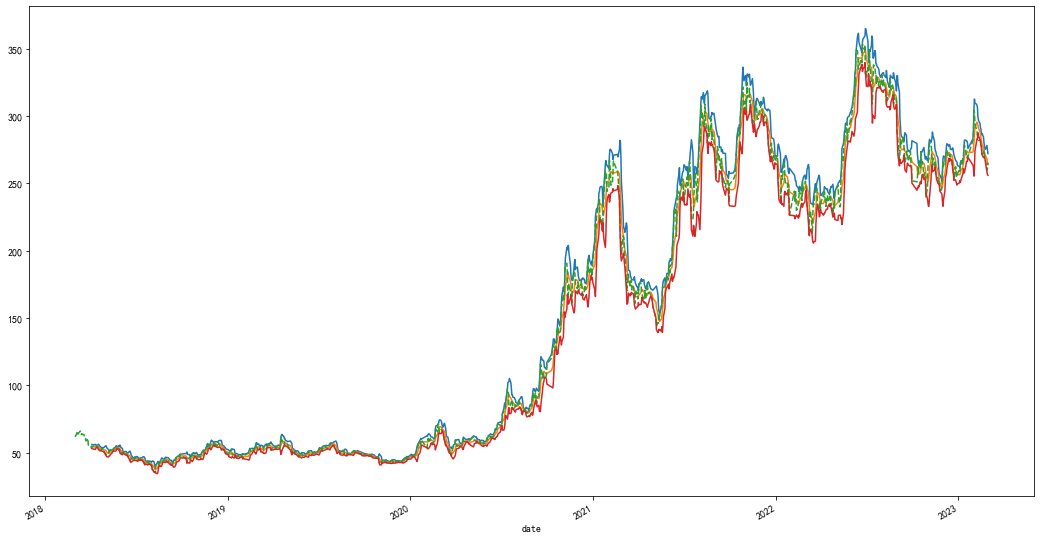

In [9]:
upper.plot(figsize=(18,10))
middle.plot()
stock_byd.close.plot(style="--")
lower.plot()